In [2]:
!pip install pystan==2.19.1.1
!pip install prophet

In [1]:
import os
import glob
import csv
import sys
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.linear_model import BayesianRidge

from darts.metrics import mae
from darts.metrics import mse
from darts.metrics import rmse

import random
from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly
from prophet.plot import add_changepoints_to_plot
import datetime

from darts import TimeSeries
from darts.dataprocessing.transformers import Scaler

In [2]:
def interpolate_method(df,column_name,methode,direction,order,limit):
  df[column_name] = df[column_name].interpolate(method=methode,limit_direction = direction,order=order,limit=limit)
  return df

def clean_csv(df,time_variable,quantitative_variable):
  df = df[[time_variable, quantitative_variable]].copy()
  df.columns = ['ds','y']
  df['y'] = (df['y'].apply(pd.to_numeric, errors='coerce')).to_frame()
  df = df.drop_duplicates(subset=['ds'])
  df['ds'] = pd.to_datetime(df.ds, errors = 'coerce')
  df = df.dropna(subset=['ds'])
  df = df.sort_values(by=['ds'])
  pourcentage = ((len(df) - df['y'].count()) / len(df)) * 100
  if (pourcentage <= 2):
    df = df.dropna(subset=['y'])
  elif((pourcentage > 2) and (pourcentage < 25)):
    df = interpolate_method(df,'y',"polynomial",None,2,None)
  elif((pourcentage >= 25)):
    print("La base de donnée comporte un grand nombre de données manquantes pour être étudiée.")
  if(len(df) > 1000):
      supr = len(df) - 1000
      df = df[:-supr]
  return df, pourcentage

In [3]:
def naive_method(df):
  if len(df.columns) > 2:
    print("Erreur : il y a plus d'une seule variable")
  elif(len(df) < 500):
      print("Erreur : le data frame est trop petit")
  else:
    n = len(df)
    period = 200
    train_len = n-period
    train = df[0:train_len]
    val = df[train_len:]
    
    series = TimeSeries.from_dataframe(df, 'ds', 'y')
    train_scaled = TimeSeries.from_dataframe(train, 'ds', 'y')
    val_scaled = TimeSeries.from_dataframe(val, 'ds', 'y')
    
    scaler = Scaler()
    train_scaled = scaler.fit_transform(train_scaled)
    val_scaled = scaler.transform(val_scaled)
    series_scaled = scaler.transform(series)
        
    y_hat_naive = val.copy()
    y_hat_naive['naive_forecast'] = train['y'][train_len-1]
    
    y_hat_naive_scaled = TimeSeries.from_dataframe(y_hat_naive, 'ds', 'naive_forecast')
    y_hat_naive_scaled = scaler.transform(y_hat_naive_scaled)
    
    MAE = mae(val_scaled,y_hat_naive_scaled)
    MSE = mse(val_scaled,y_hat_naive_scaled)
    RMSE = rmse(val_scaled,y_hat_naive_scaled)


    return(train_scaled, val_scaled, y_hat_naive_scaled, MAE, MSE, RMSE)

In [4]:
def prophet_model(df,frequency):
  if len(df.columns) > 2:
    print("Erreur : il y a plus d'une seule variable")
  elif(len(df) < 500):
    print("Erreur : le data frame est trop petit")
  else:
    n = len(df)
    period = 200
    df_fit = df[:-period]
    df_true = df[n-period:]
    
    series = TimeSeries.from_dataframe(df, 'ds', 'y')
    train = TimeSeries.from_dataframe(df_fit, 'ds', 'y')
    val = TimeSeries.from_dataframe(df_true, 'ds', 'y')
    
    scaler = Scaler()
    train_scaled = scaler.fit_transform(train)
    val_scaled = scaler.transform(val)
    series_scaled = scaler.transform(series)
    
    m = Prophet(daily_seasonality=True, weekly_seasonality=True, yearly_seasonality = True)
    m.fit(df_fit)
    future = m.make_future_dataframe(periods=period*2, freq=frequency)
    if (frequency == 'M'):
        for i in range (n-period, len(future)):
            future['ds'][i] = future['ds'][i] + datetime.timedelta(days=1)
    forecast = m.predict(future)
    df_true_prediction = pd.merge(df_true, forecast, how ='inner', on =['ds'])
    df_true_prediction = df_true_prediction[['ds', 'y', 'yhat', 'yhat_upper', 'yhat_lower']].copy()
    
    pred = TimeSeries.from_dataframe(df_true_prediction, 'ds', 'yhat')
    pred_scaled = scaler.transform(pred)
    
    MAE = mae(val_scaled,pred_scaled)
    MSE = mse(val_scaled,pred_scaled)
    RMSE = rmse(val_scaled, pred_scaled)
    
    return(train_scaled, val_scaled, pred_scaled, MAE, MSE, RMSE)

In [5]:
os.getcwd()

'/home/nazim/MAIN4/Transformers/Code/800-200'

In [6]:
os.chdir('../../Datasets/Bourse')
os.getcwd()

'/home/nazim/MAIN4/Transformers/Datasets/Bourse'

In [7]:
!ls

D-ADA_USDT.csv	D-eos.csv	D-link.csv  D-TRX_USDT.csv  D-ZEC_USDT.csv
D-bitcoin.csv	D-ETC_USDT.csv	D-ltc.csv   D-XLM_USDT.csv
D-bnb.csv	D-eth.csv	D-neo.csv   D-xrp.csv


In [8]:
def predict():
    file_name = []
    df = []
    pourcentage = []

    df_fit_naive = []
    df_true_prediction_naive = []
    forecast_naive = []

    df_fit_prophet = []
    df_true_prediction_prophet = []
    forecast_prophet = []

    results_naive = pd.DataFrame(columns=['DATA_SET_NAME','Method','MAE','MSE','RMSE'])
    results_prophet = pd.DataFrame(columns=['DATA_SET_NAME','Method','MAE','MSE','RMSE'])

    i = 0
    for files in glob.glob("*.csv"):
        file_name.append(Path(files).stem)
        print(file_name[i])
        df_not_cleaned = pd.read_csv(files)
        df_clean, pourcentage_actual = clean_csv(df_not_cleaned, "ds","Value")
        df.append(df_clean)
        pourcentage.append(pourcentage_actual)

        df_fit_temp_naive , df_true_prediction_temp_naive , forecast_temp_naive , MAE_naive, MSE_naive, RMSE_naive = naive_method(df[i])
        df_fit_naive.append(df_fit_temp_naive)
        df_true_prediction_naive.append(df_true_prediction_temp_naive)
        forecast_naive.append(forecast_temp_naive)

        df_fit_temp_prophet , df_true_prediction_temp_prophet , forecast_temp_prophet , MAE_prophet, MSE_prophet, RMSE_prophet = prophet_model(df[i],file_name[i][0])
        df_fit_prophet.append(df_fit_temp_prophet)
        df_true_prediction_prophet.append(df_true_prediction_temp_prophet)
        forecast_prophet.append(forecast_temp_prophet)

        df_new_row_naive = pd.DataFrame(data=np.array([[file_name[i],'Naive Method',MAE_naive,MSE_naive,RMSE_naive]]), columns=['DATA_SET_NAME','Method','MAE','MSE','RMSE'])
        df_new_row_prophet = pd.DataFrame(data=np.array([[file_name[i],'Prophet Method',MAE_prophet,MSE_prophet,RMSE_prophet]]), columns=['DATA_SET_NAME','Method','MAE','MSE','RMSE'])
        results_naive = pd.concat([results_naive,df_new_row_naive], ignore_index=True)
        results_prophet = pd.concat([results_prophet,df_new_row_prophet], ignore_index=True)
        i = i +1

    return file_name,df, pourcentage, df_fit_naive, df_true_prediction_naive, forecast_naive, results_naive, df_fit_prophet, df_true_prediction_prophet, forecast_prophet, results_prophet

In [9]:
file_name, df, pourcentage, df_fit_naive, df_true_prediction_naive, forecast_naive, results_naive, df_fit_prophet, df_true_prediction_prophet, forecast_prophet, results_prophet = predict()

D-ZEC_USDT
Initial log joint probability = -12.0566
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99          1829   0.000547516       266.789      0.4774      0.4774      117   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1839.98    0.00316305       121.215      0.3185           1      232   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     210        1840.7   0.000237926       171.078   2.096e-06       0.001      275  LS failed, Hessian reset 
     239       1841.43   0.000260605       168.725   2.448e-06       0.001      347  LS failed, Hessian reset 
     271       1841.86   0.000206567       83.5902   6.087e-07       0.001      425  LS failed, Hessian reset 
     299       1842.19   5.93911e-06       70.4455      0.3944      0.3944      462   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # 

D-eos
Initial log joint probability = -28.3124
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1923.41     0.0206114       795.019      0.2634           1      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1964.94     0.0255018       298.212           1           1      240   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1988.88    0.00162491       266.599      0.5615      0.5615      364   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1995.07    0.00614214       535.382      0.3525      0.3525      490   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       2003.88   0.000477708       289.185     0.06343           1      625   
    Iter      log prob        ||dx||      ||grad||       a

Initial log joint probability = -22.3518
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1992.97      0.069005       320.409           1           1      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     197       2011.94    8.2163e-05       127.202   5.776e-07       0.001      277  LS failed, Hessian reset 
     199        2012.1    0.00399117       266.418          10           1      281   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     267       2017.78   0.000116954       180.167   8.687e-07       0.001      404  LS failed, Hessian reset 
     299       2022.47    0.00036666         204.5     0.09913      0.6871      444   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       2025.42   0.000249621       82.2062      0.4709      0.4709      577   
    Iter      log pro

D-xrp
Initial log joint probability = -39.8521
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2034.14      0.034267       319.322           1           1      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       2063.35   0.000652955       231.673      0.5752      0.5752      245   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       2081.87   0.000992442       147.435      0.5591      0.5591      367   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       2084.38    0.00103952       383.716           1           1      493   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       2090.23    0.00359348       205.929           1           1      610   
    Iter      log prob        ||dx||      ||grad||       a

In [10]:
df

[            ds        y
 0   2019-03-21   56.205
 1   2019-03-22   55.490
 2   2019-03-23   55.840
 3   2019-03-24   57.125
 4   2019-03-25   55.455
 ..         ...      ...
 995 2021-12-10  166.400
 996 2021-12-11  163.550
 997 2021-12-12  166.950
 998 2021-12-13  159.050
 999 2021-12-14  149.700
 
 [1000 rows x 2 columns],
             ds        y
 0   2017-12-18  318.980
 1   2017-12-19  334.985
 2   2017-12-20  308.500
 3   2017-12-21  296.085
 4   2017-12-22  246.290
 ..         ...      ...
 995 2020-09-08   47.665
 996 2020-09-09   47.665
 997 2020-09-10   48.610
 998 2020-09-11   48.480
 999 2020-09-12   49.845
 
 [1000 rows x 2 columns],
             ds         y
 0   2018-06-12  15.37495
 1   2018-06-13  13.89305
 2   2018-06-14  13.74545
 3   2018-06-15  13.81515
 4   2018-06-16  14.31995
 ..         ...       ...
 995 2021-03-03  11.27685
 996 2021-03-04  11.19975
 997 2021-03-05  10.71620
 998 2021-03-06  10.94240
 999 2021-03-07  11.45200
 
 [1000 rows x 2 columns],
    

In [11]:
results_naive

,DATA_SET_NAME,Method,MAE,MSE,RMSE
0,D-ZEC_USDT,Naive Method,0.09430314697020423,0.014407224529707965,0.12003009843246804
1,D-ltc,Naive Method,0.08175907072197015,0.007277084959231181,0.08530583191805342
2,D-ETC_USDT,Naive Method,0.11722395958624011,0.027057256955397554,0.16449090234842034
3,D-TRX_USDT,Naive Method,0.13187569919204475,0.04243571813459175,0.20599931585952355
4,D-bitcoin,Naive Method,0.06819666067677421,0.007136018804972772,0.08447495963285671
5,D-eos,Naive Method,0.02949307896599219,0.0016664181283194248,0.04082178497223541
6,D-neo,Naive Method,0.020855943933367992,0.0005861031515741713,0.024209567356195595
7,D-eth,Naive Method,0.02546417113150918,0.0010611288655423478,0.032574972993731674
8,D-link,Naive Method,0.17454391374277364,0.05550010790735234,0.2355846088082843
9,D-bnb,Naive Method,0.12498602817809491,0.021322267683412305,0.14602146309160274


In [12]:
results_prophet

,DATA_SET_NAME,Method,MAE,MSE,RMSE
0,D-ZEC_USDT,Prophet Method,0.5152402454363609,0.2760173107579572,0.525373496436542
1,D-ltc,Prophet Method,0.26700035024432606,0.07763338204133965,0.2786276763735786
2,D-ETC_USDT,Prophet Method,0.32959736433703896,0.15442511872389864,0.3929696155224964
3,D-TRX_USDT,Prophet Method,0.3563957447794749,0.15395838554303037,0.3923753120967607
4,D-bitcoin,Prophet Method,0.12271984900188855,0.021214908388245152,0.1456533844036765
5,D-eos,Prophet Method,0.06360562270868778,0.0066545551463616705,0.08157545676465239
6,D-neo,Prophet Method,0.22569530585692132,0.06236288340885288,0.24972561624481554
7,D-eth,Prophet Method,0.2539786338900134,0.0787739076367587,0.2806668980067986
8,D-link,Prophet Method,0.584903072584124,0.4534976499883576,0.6734223414680847
9,D-bnb,Prophet Method,0.5365014068487496,0.3215574080660679,0.5670603213645511


In [13]:
results_prophet.to_csv(r'../../Resultats/Resultats_200/prophet_results_bourse.csv', index = False)
results_naive.to_csv(r'../../Resultats/Resultats_200/naive_results_bourse.csv', index = False)

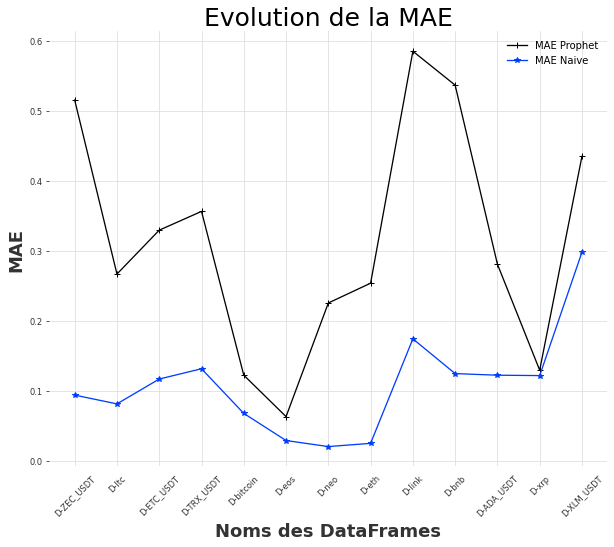

In [14]:
figure(figsize=(10, 8))
plt.axes()

liste_MAE1_prophet = results_prophet["MAE"].tolist()
liste_MAE_prophet = [float(item) for item in liste_MAE1_prophet]

liste_MAE1_naive = results_naive["MAE"].tolist()
liste_MAE_naive = [float(item) for item in liste_MAE1_naive]

x = np.array([0,1,2,3,4,5,6,7,8,9,10,11,12])
y = np.array(liste_MAE_prophet)
y2 = np.array(liste_MAE_naive)

liste_NAME = results_prophet["DATA_SET_NAME"].tolist()
my_xticks = liste_NAME
plt.xticks(x, my_xticks)
plt.xticks(rotation=45)
plt.plot(x, y, label = 'MAE Prophet', marker="+")
plt.plot(x, y2, label = 'MAE Naive', marker="*")
plt.title("Evolution de la MAE",fontsize=25)
plt.xlabel("Noms des DataFrames",fontsize=18)
plt.ylabel("MAE",fontsize=18)
plt.legend()
plt.show()

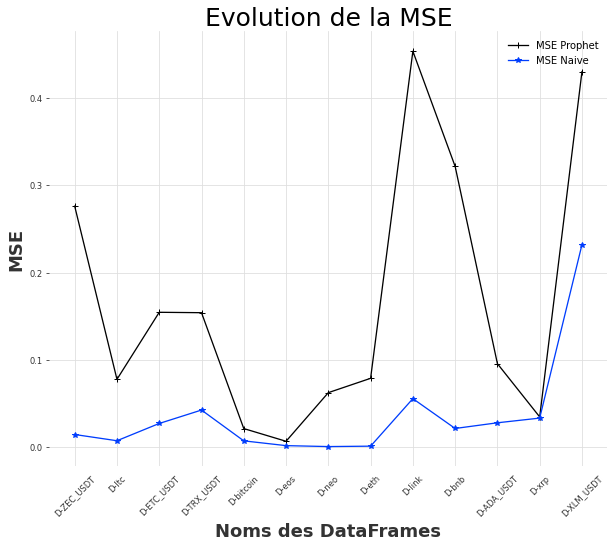

In [15]:
figure(figsize=(10, 8))
plt.axes()

liste_MSE1_prophet = results_prophet["MSE"].tolist()
liste_MSE_prophet = [float(item) for item in liste_MSE1_prophet]

liste_MSE1_naive = results_naive["MSE"].tolist()
liste_MSE_naive = [float(item) for item in liste_MSE1_naive]

x = np.array([0,1,2,3,4,5,6,7,8,9,10,11,12])
y = np.array(liste_MSE_prophet)
y2 = np.array(liste_MSE_naive)

liste_NAME = results_prophet["DATA_SET_NAME"].tolist()
my_xticks = liste_NAME
plt.xticks(x, my_xticks)
plt.xticks(rotation=45)
plt.plot(x, y, label = 'MSE Prophet', marker="+")
plt.plot(x, y2, label = 'MSE Naive', marker="*")
plt.title("Evolution de la MSE",fontsize=25)
plt.xlabel("Noms des DataFrames",fontsize=18)
plt.ylabel("MSE",fontsize=18)
plt.legend()
plt.show()

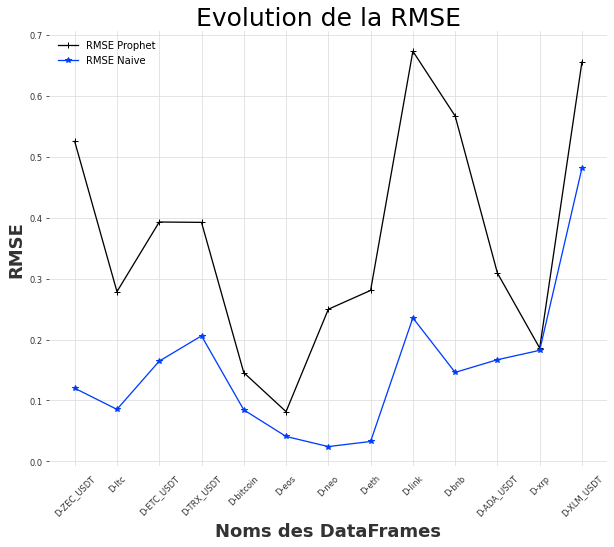

In [16]:
figure(figsize=(10, 8))
plt.axes()

liste_RMSE1_prophet = results_prophet["RMSE"].tolist()
liste_RMSE_prophet = [float(item) for item in liste_RMSE1_prophet]

liste_RMSE1_naive = results_naive["RMSE"].tolist()
liste_RMSE_naive = [float(item) for item in liste_RMSE1_naive]

x = np.array([0,1,2,3,4,5,6,7,8,9,10,11,12])
y = np.array(liste_RMSE_prophet)
y2 = np.array(liste_RMSE_naive)

liste_NAME = results_prophet["DATA_SET_NAME"].tolist()
my_xticks = liste_NAME
plt.xticks(x, my_xticks)
plt.xticks(rotation=45)
plt.plot(x, y, label = 'RMSE Prophet', marker="+")
plt.plot(x, y2, label = 'RMSE Naive', marker="*")
plt.title("Evolution de la RMSE",fontsize=25)
plt.xlabel("Noms des DataFrames",fontsize=18)
plt.ylabel("RMSE",fontsize=18)
plt.legend()
plt.show()

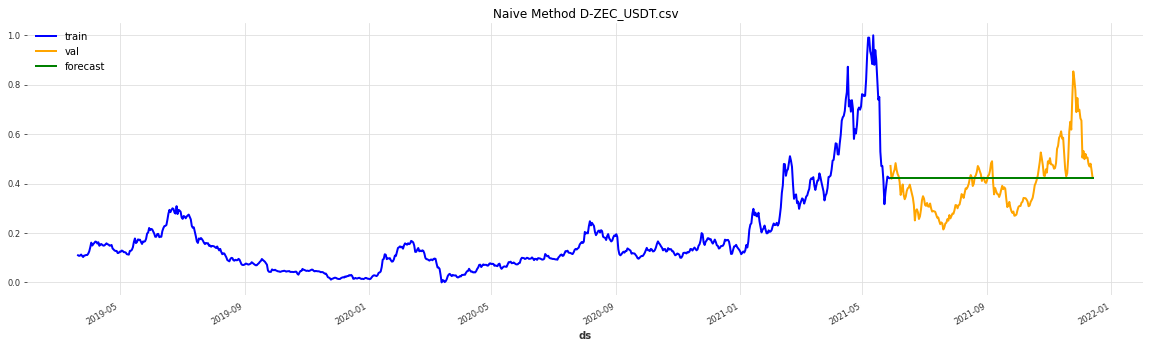

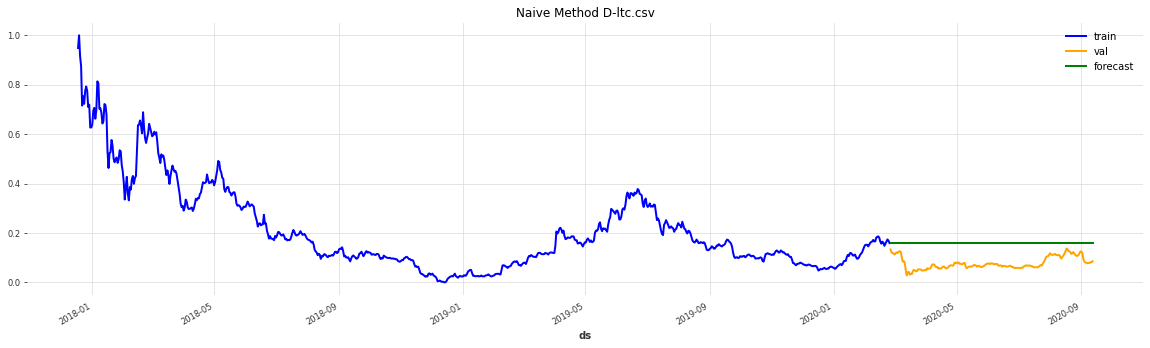

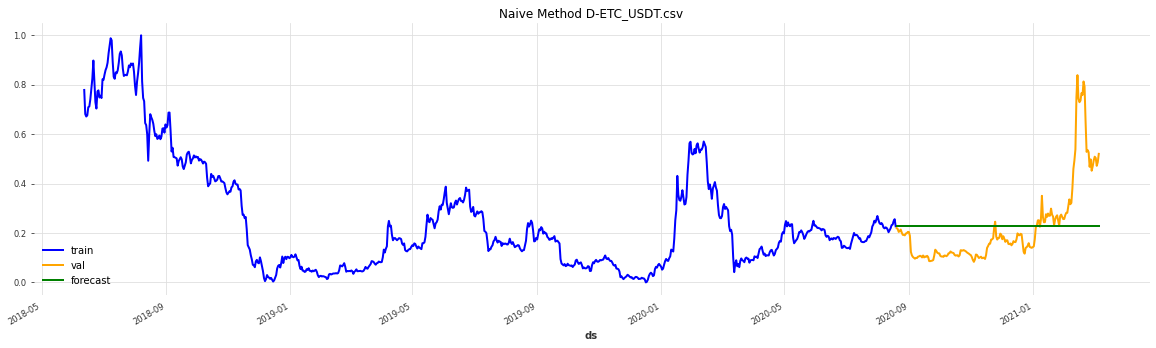

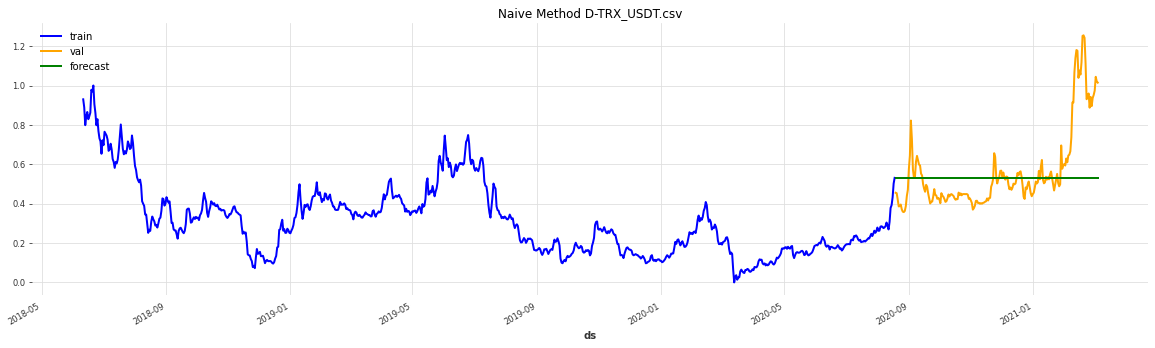

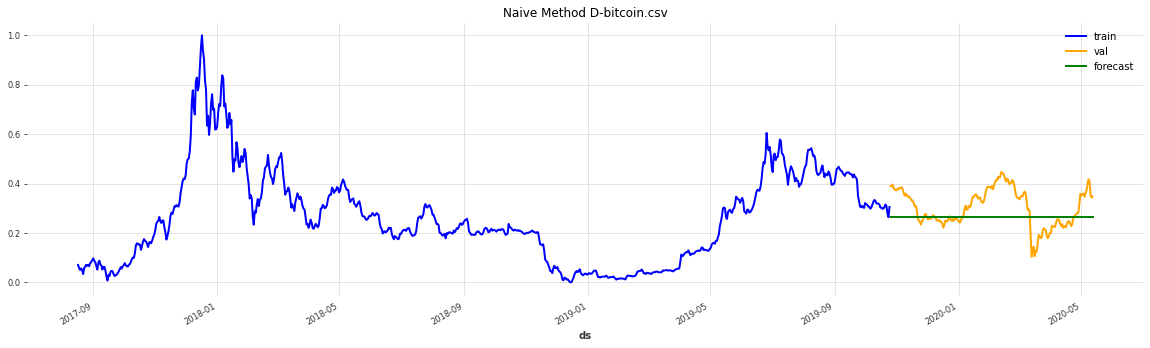

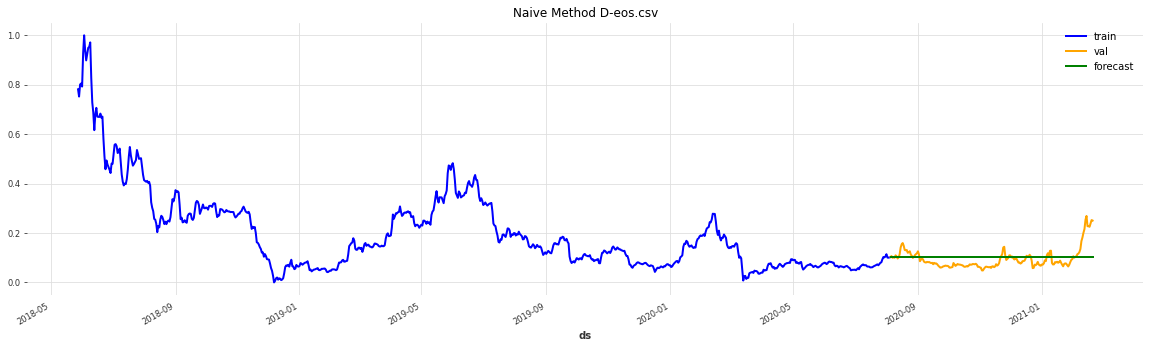

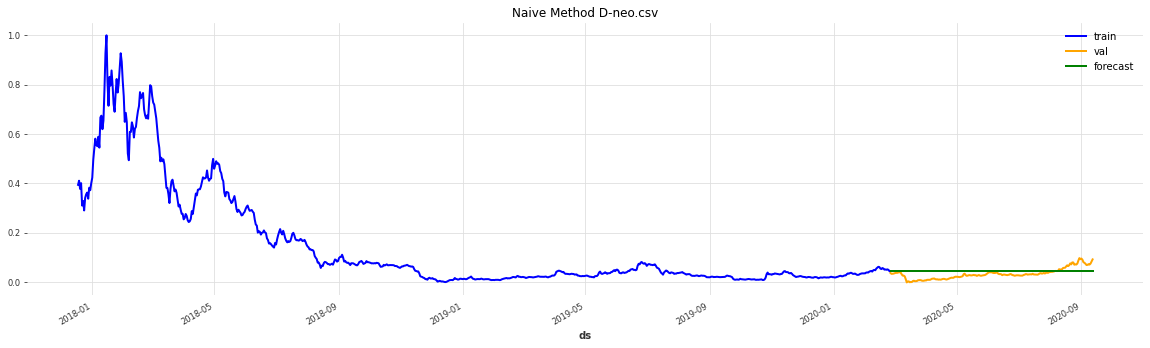

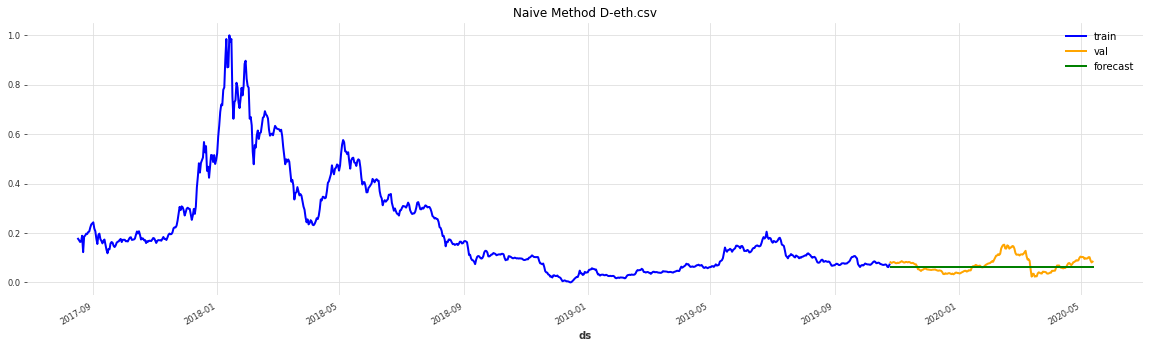

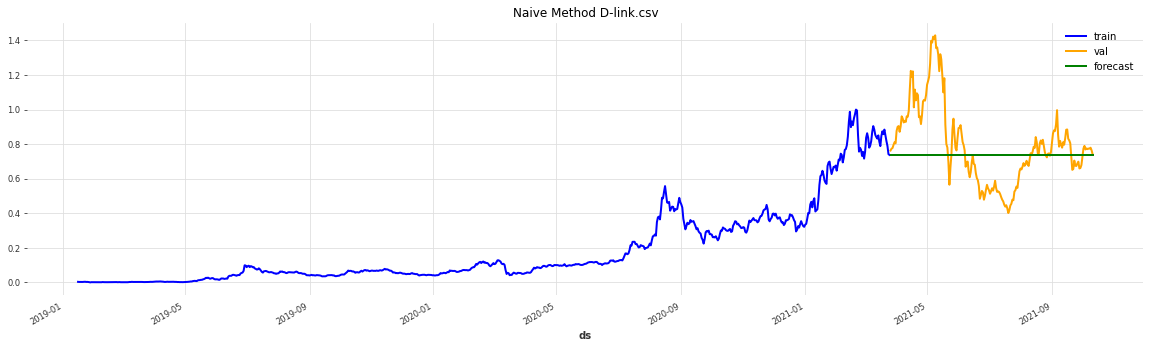

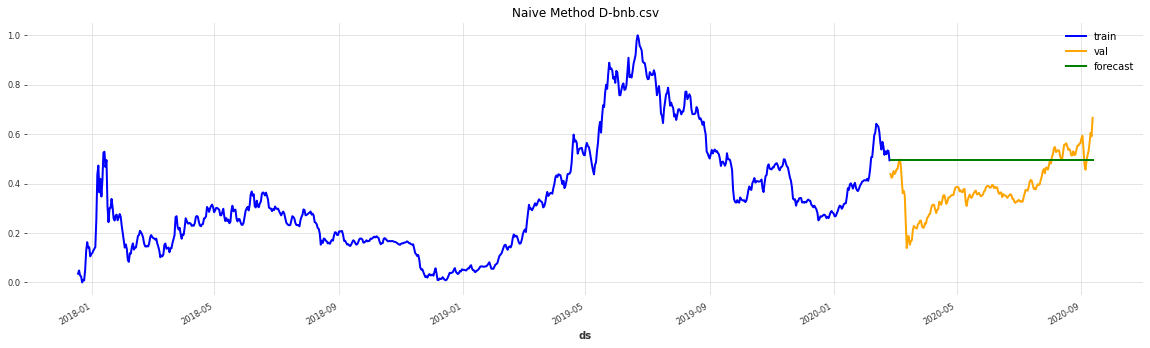

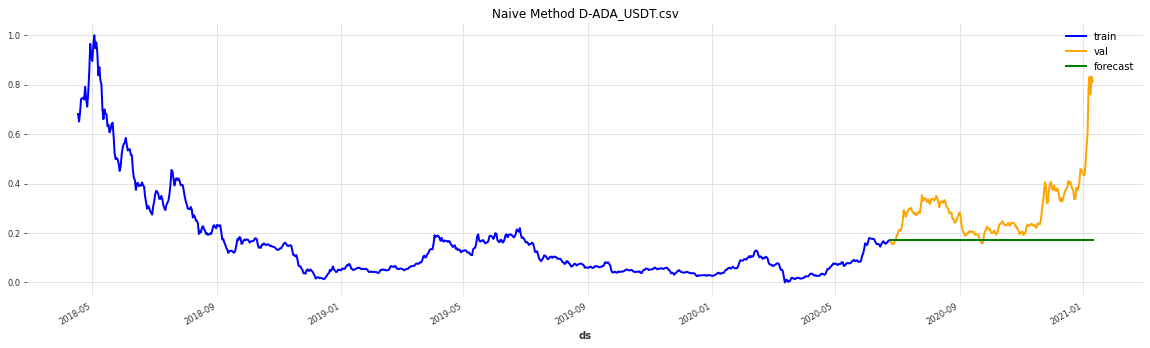

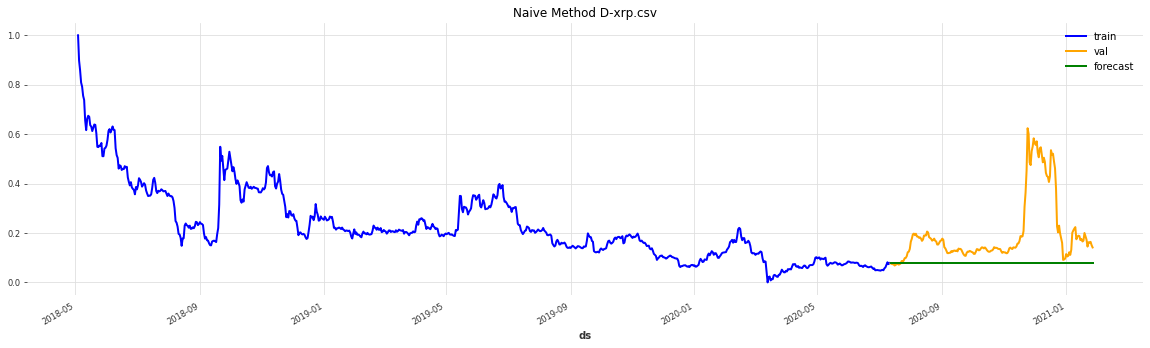

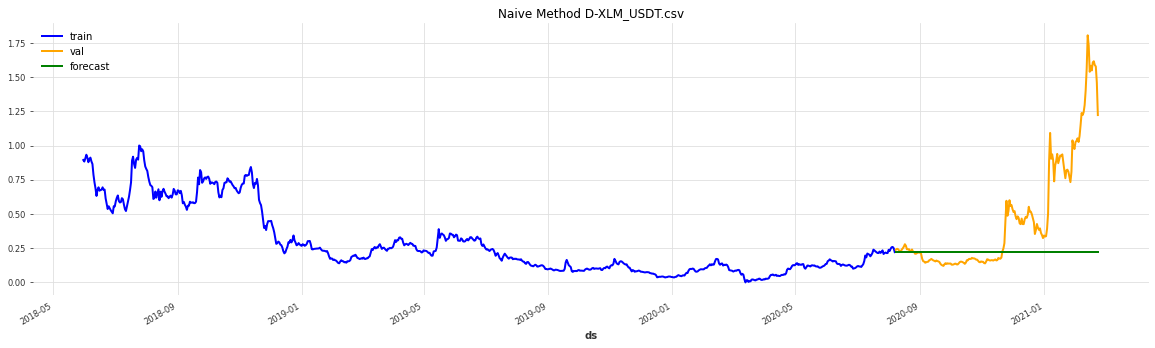

In [18]:
for i in range(len(df_fit_naive)):
    plt.figure(figsize=(20,5))
    df_fit_naive[i].plot(color ='blue', label="train")
    df_true_prediction_naive[i].plot(color ='orange', label="val")
    forecast_naive[i].plot(color ='green',label="forecast")
    plt.title('Naive Method '+file_name[i]+".csv")    
    plt.legend(loc='best')
    plt.show()

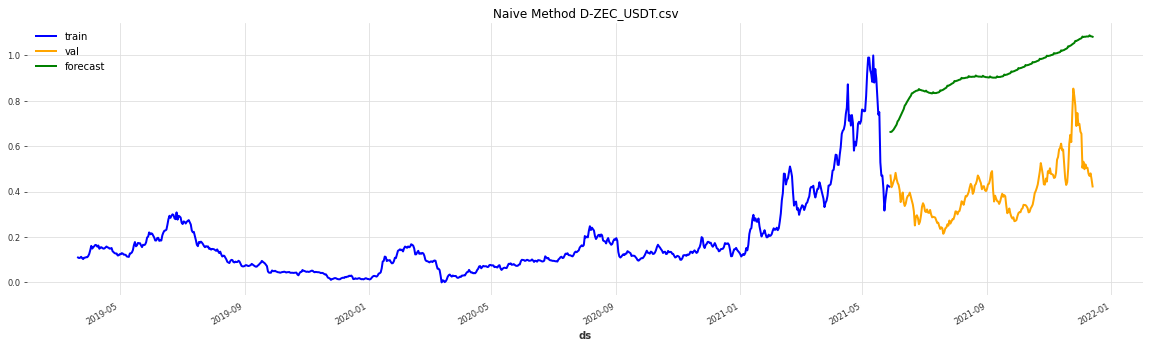

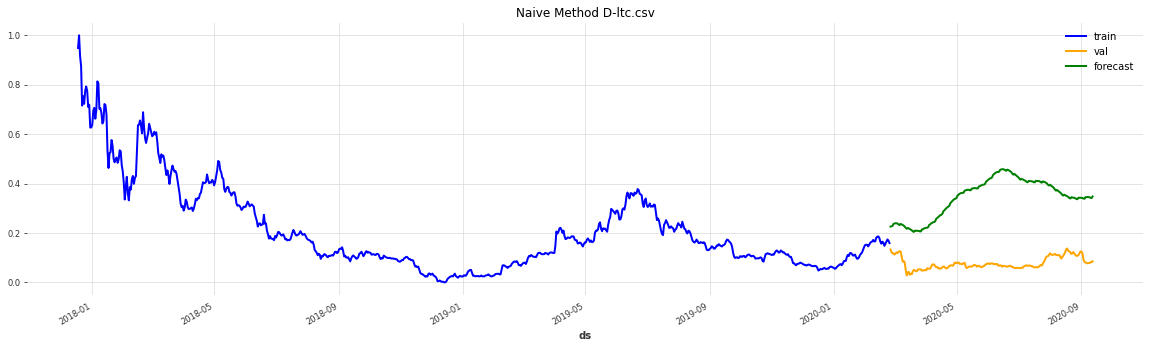

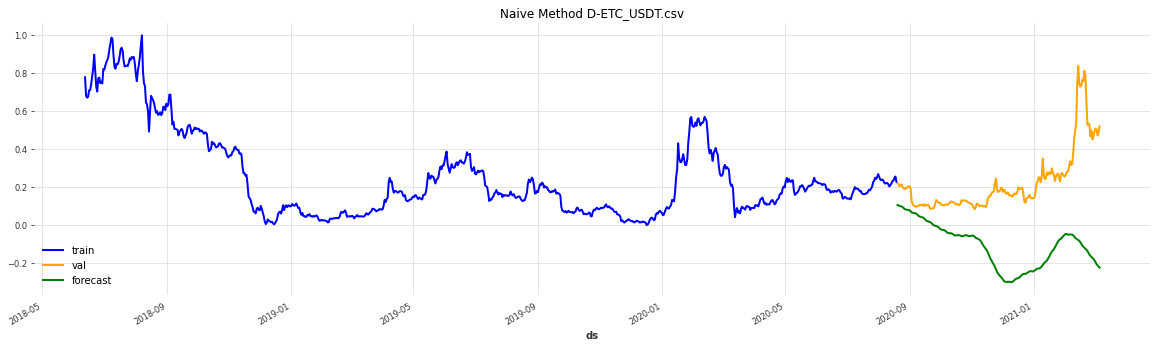

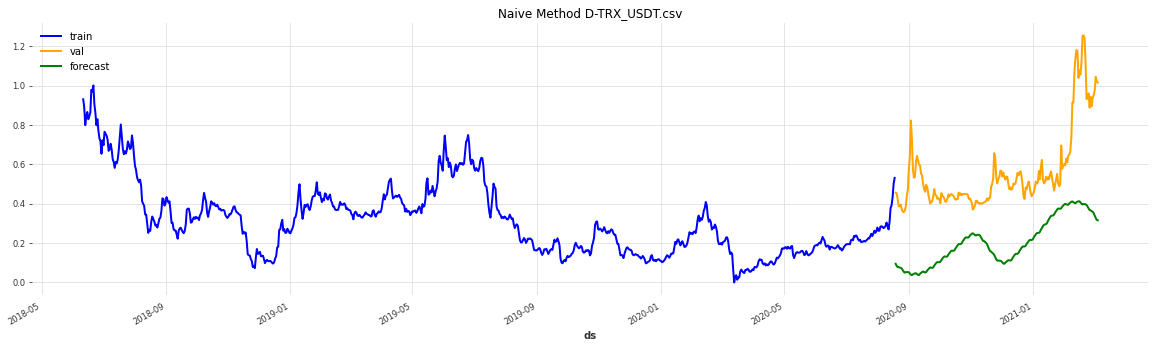

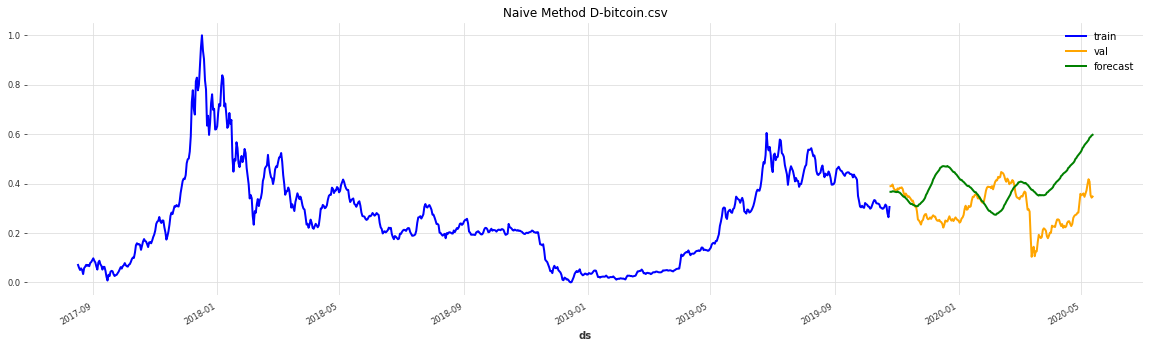

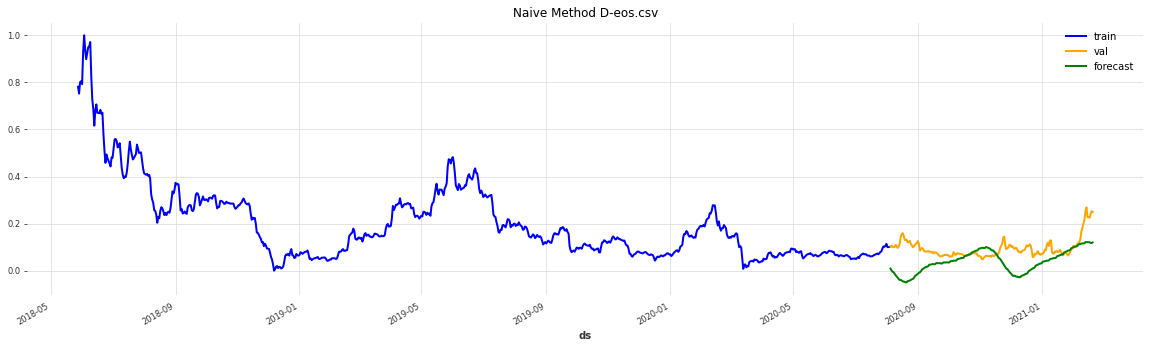

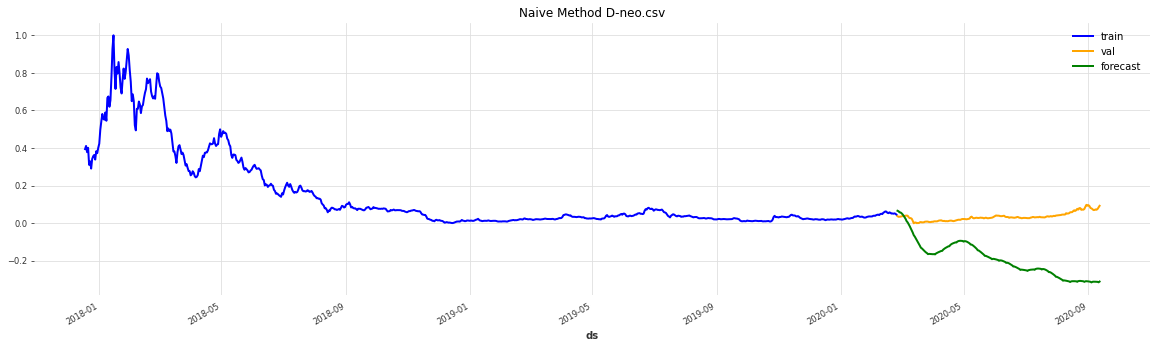

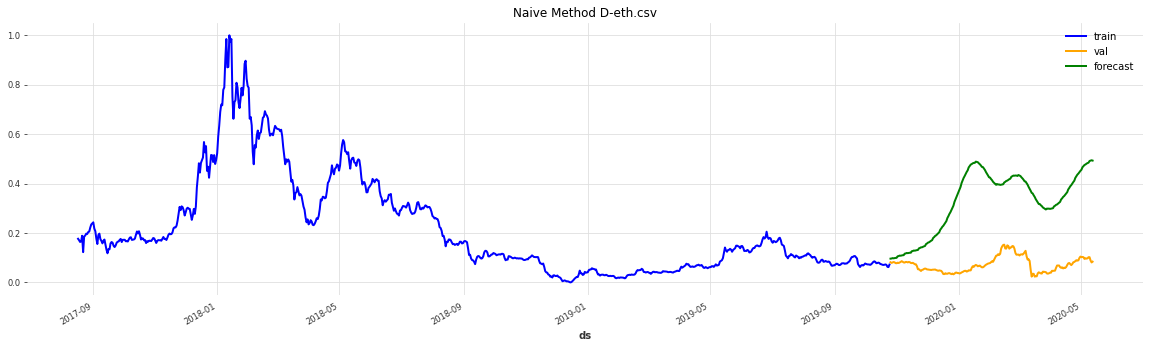

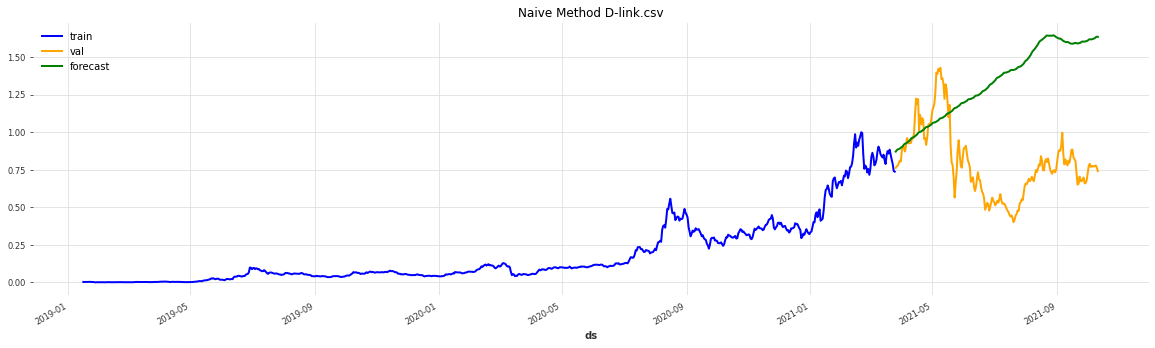

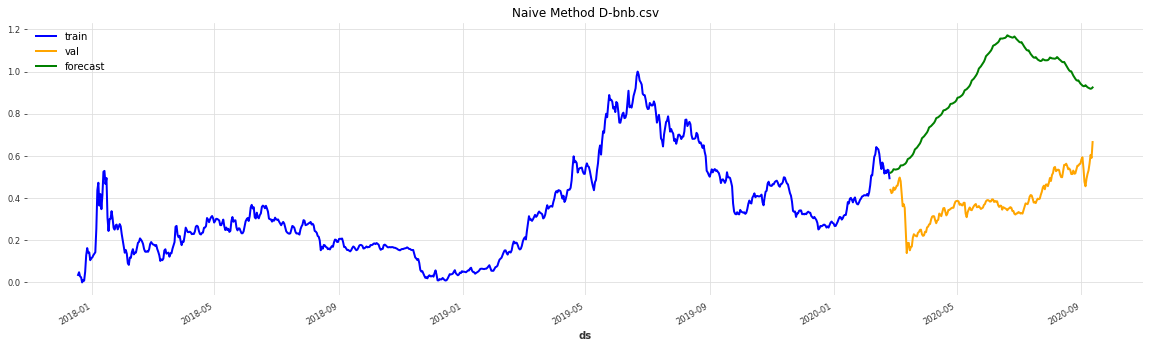

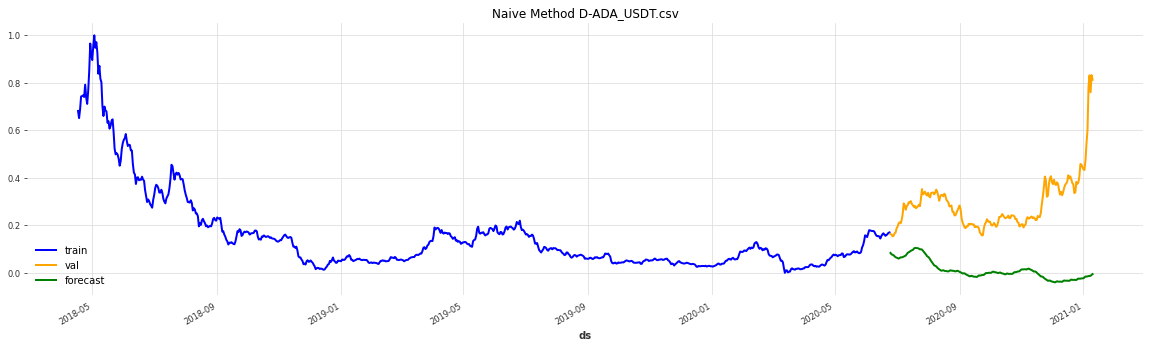

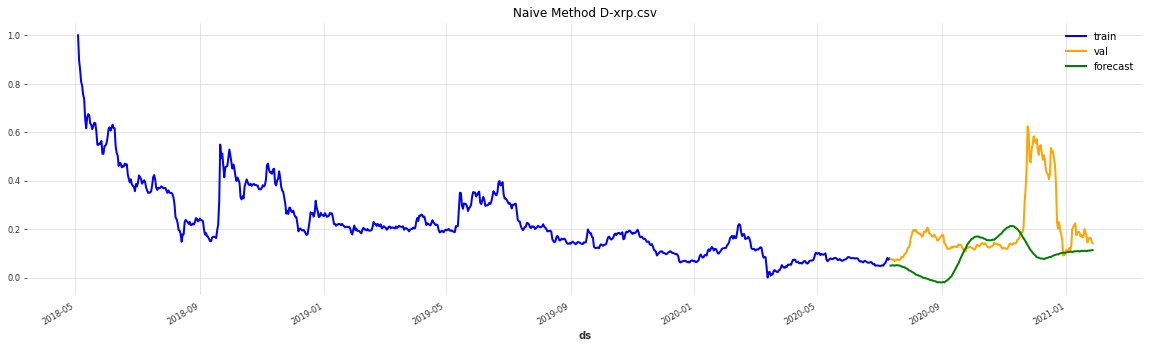

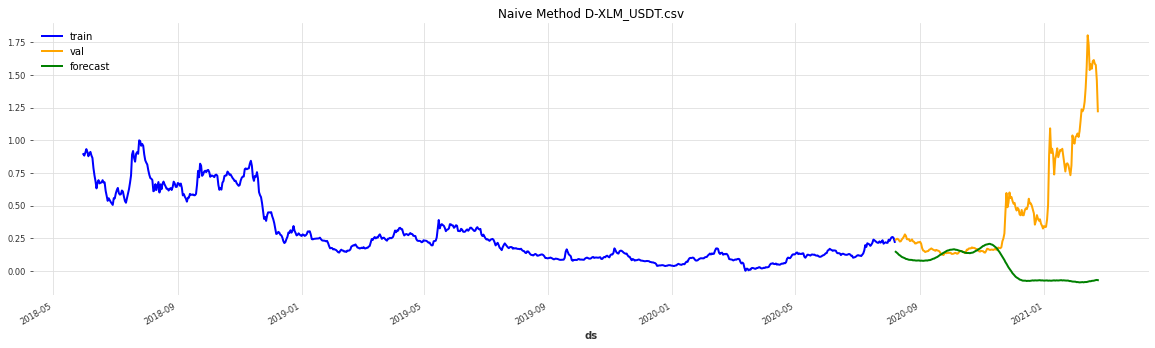

In [19]:
for i in range(len(df_fit_prophet)):
    plt.figure(figsize=(20,5))
    df_fit_prophet[i].plot(color ='blue', label="train")
    df_true_prediction_prophet[i].plot(color ='orange', label="val")
    forecast_prophet[i].plot(color ='green',label="forecast")
    plt.title('Naive Method '+file_name[i]+".csv")    
    plt.legend(loc='best')
    plt.show()

In [20]:
for i in range(len(df_fit_naive)):
    if len(df_fit_naive[i]) != 800 :
        print("ERROR, len(df_fit_naive[{}]) = {}".format(i, len(df_fit_naive[i])))
    elif len(df_true_prediction_naive[i]) != 200 :
        print("ERROR, len(df_true_prediction_naive[{}]) = {}".format(i, len(df_true_prediction_naive[i])))
    else:
        print("Tout est bon pour data i = ", i)
    print("-----")

Tout est bon pour data i =  0
-----
Tout est bon pour data i =  1
-----
Tout est bon pour data i =  2
-----
Tout est bon pour data i =  3
-----
Tout est bon pour data i =  4
-----
Tout est bon pour data i =  5
-----
Tout est bon pour data i =  6
-----
Tout est bon pour data i =  7
-----
Tout est bon pour data i =  8
-----
Tout est bon pour data i =  9
-----
Tout est bon pour data i =  10
-----
Tout est bon pour data i =  11
-----
Tout est bon pour data i =  12
-----


In [21]:
for i in range(len(df_fit_prophet)):
    if len(df_fit_prophet[i]) != 800 :
        print("ERROR, len(df_fit_prophet[{}] = {}".format(i, len(df_fit_prophet[i])))
    elif len(df_true_prediction_prophet[i]) != 200 :
        print("ERROR, len(df_true_prediction_prophet[{}] = {}".format(i, len(df_true_prediction_prophet[i])))
    else:
        print("Tout est bon pour data i = ", i)
    print("-----")

Tout est bon pour data i =  0
-----
Tout est bon pour data i =  1
-----
Tout est bon pour data i =  2
-----
Tout est bon pour data i =  3
-----
Tout est bon pour data i =  4
-----
Tout est bon pour data i =  5
-----
Tout est bon pour data i =  6
-----
Tout est bon pour data i =  7
-----
Tout est bon pour data i =  8
-----
Tout est bon pour data i =  9
-----
Tout est bon pour data i =  10
-----
Tout est bon pour data i =  11
-----
Tout est bon pour data i =  12
-----
